
# Real-World Example: Conformal Prediction on Renin Inhibitor Data

This notebook demonstrates robust benchmarking of conformal prediction (CP) methods on a real molecular dataset (`renin_harren.csv`). We compare CP to standard uncertainty quantification (UQ) methods and ML models, using advanced metrics. All steps are NaN-safe and ready for direct use.


In [6]:
# 1. Import Required Libraries and Define Utility Functions
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    average_precision_score,
    balanced_accuracy_score,
    brier_score_loss,
    f1_score,
    log_loss,
    matthews_corrcoef,
    roc_auc_score,
)
from sklearn.model_selection import StratifiedKFold, train_test_split

from molpipeline.any2mol import SmilesToMol
from molpipeline.error_handling import ErrorFilter, FilterReinserter
from molpipeline.experimental.uncertainty.conformal import (
    CrossConformalCV,
)
from molpipeline.mol2any.mol2morgan_fingerprint import MolToMorganFP
from molpipeline.pipeline import Pipeline
from molpipeline.post_prediction import PostPredictionWrapper

THRESHOLD = 0.5


def compute_ece(y_true: np.ndarray, probs: np.ndarray, n_bins: int = 10) -> float:
    """Compute Expected Calibration Error (ECE).

    Parameters
    ----------
    y_true : np.ndarray
        True binary labels.
    probs : np.ndarray
        Predicted probabilities.
    n_bins : int, optional
        Number of bins (default: 10).

    Returns
    -------
    float
        Expected calibration error.

    """
    bins = np.linspace(0, 1, n_bins + 1)
    binids = np.digitize(probs, bins) - 1
    ece = 0.0
    for i in range(n_bins):
        mask = binids == i
        if np.any(mask):
            acc = np.mean(y_true[mask] == (probs[mask] >= THRESHOLD))
            conf = np.mean(probs[mask])
            ece += np.abs(acc - conf) * np.sum(mask) / len(y_true)
    return ece


def uncertain_error_corr(y_true: np.ndarray, probs: np.ndarray) -> float:
    """Compute correlation between uncertainty and error.

    Parameters
    ----------
    y_true : np.ndarray
        True binary labels.
    probs : np.ndarray
        Predicted probabilities.

    Returns
    -------
    float
        Correlation coefficient between entropy and error.

    """
    eps = 1e-12
    entropy = -probs * np.log(probs + eps) - (1 - probs) * np.log(1 - probs + eps)
    error = np.abs(y_true - (probs >= THRESHOLD))
    return np.corrcoef(entropy, error)[0, 1]


def compute_sharpness(probs: np.ndarray) -> float:
    """Compute sharpness (mean entropy) of predicted probabilities.

    Parameters
    ----------
    probs : np.ndarray
        Predicted probabilities.

    Returns
    -------
    float
        Mean entropy of predicted probabilities.

    """
    eps = 1e-12
    entropy = -probs * np.log(probs + eps) - (1 - probs) * np.log(1 - probs + eps)
    return np.mean(entropy)


ModuleNotFoundError: No module named 'matplotlib'

In [2]:
# 2. Data Loading, Cleaning, and Featurization
# Load real data
df = pd.read_csv("example_data/renin_harren.csv")
smiles = df["pubchem_smiles"].to_numpy()
y_reg = df["pIC50"].to_numpy()

# Binarize for classification: top 20% as 'active'
threshold = np.nanquantile(y_reg, 0.8)
y_class = (y_reg >= threshold).astype(int)

# Featurization pipeline (NaN-safe)
error_filter = ErrorFilter(filter_everything=True)
error_replacer = FilterReinserter.from_error_filter(error_filter, fill_value=np.nan)
featurizer = Pipeline([
    ("smi2mol", SmilesToMol()),
    ("error_filter", error_filter),
    ("morgan", MolToMorganFP(radius=2, n_bits=256, return_as="dense")),
    ("error_replacer", PostPredictionWrapper(error_replacer)),
], n_jobs=1)
X_feat = featurizer.transform(smiles)

print(f"Shape of X={X_feat.shape}, y_class={y_class.shape}, y_reg={y_reg.shape}")

# Generate indices for a single split
indices = np.arange(len(y_class))
train_idx, test_idx = train_test_split(
    indices, test_size=0.3, random_state=42, stratify=y_class,
)

# Use these indices for all splits
X_train, X_test = X_feat[train_idx], X_feat[test_idx]
y_train, y_test = y_class[train_idx], y_class[test_idx]
smiles_train, smiles_test = smiles[train_idx], smiles[test_idx]

NameError: name 'pd' is not defined

In [ ]:
# 3.1 Cross-Validation Benchmarking: Standard Models and Conformal Prediction

# Use StratifiedKFold on the training set
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model_dict = {
    "ensemble_rf": RandomForestClassifier(n_estimators=100, random_state=42),
}
metrics_list = [
    "NLL", "ECE", "Brier", "Uncertainty Error Correlation", "Sharpness",
    "Balanced Accuracy", "AUROC", "AUPRC", "F1 Score", "MCC",
]
results = []
results_cp = []

# Arrays to collect out-of-fold predictions
oof_preds = np.zeros_like(y_train, dtype=float)
oof_preds_cp_norm = np.zeros_like(y_train, dtype=float)
oof_preds_cp_raw = np.zeros_like(y_train, dtype=float)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    print(f"Fold {fold + 1}")
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    smiles_tr, smiles_val = smiles_train[train_idx], smiles_train[val_idx]

    # --- Standard Model ---
    for model in model_dict.values():
        model.fit(X_tr, y_tr)
        prob = model.predict_proba(X_val)[:, 1]
        oof_preds[val_idx] = prob

    # --- Conformal Prediction (CrossConformalCV) ---
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_pipeline = Pipeline([
        ("featurizer", featurizer),
        ("rf", rf),
    ], n_jobs=1)
    cc_clf = CrossConformalCV(
        estimator=rf_pipeline,
        n_folds=5,
        confidence_level=0.9,
        estimator_type="classifier",
    )
    cc_clf.fit(smiles_tr, y_tr)
    # Average ensemble probabilities for the validation fold
    probs_cp_ensemble = np.mean([m.predict_p(smiles_val) for m in cc_clf.models_],
                                 axis=0)
    probs_cp_ensemble_raw = np.mean([m.predict_proba(smiles_val) for m
                                     in cc_clf.models_],
                                     axis=0)
    p0 = probs_cp_ensemble[:, 0]
    p1 = probs_cp_ensemble[:, 1]
    p1_norm = p1 / (p0 + p1 + 1e-12)
    oof_preds_cp_norm[val_idx] = p1_norm
    oof_preds_cp_raw[val_idx] = probs_cp_ensemble_raw[:, 1]

# Create a DataFrame to compare raw and normalized conformal probabilities
df_oof_compare = pd.DataFrame({
    "y_true": y_train,
    "StandardModel": oof_preds,
    "ConformalRaw": oof_preds_cp_raw,
    "ConformalNorm": oof_preds_cp_norm,
})

# Compute metrics for out-of-fold predictions (standard model)
mean_pred = (oof_preds >= THRESHOLD).astype(int)
metrics = {
    "Model": "ensemble_xgb (OOF)",
    "NLL": log_loss(y_train, oof_preds),
    "ECE": compute_ece(y_train, oof_preds),
    "Brier": brier_score_loss(y_train, oof_preds),
    "Uncertainty Error Correlation": uncertain_error_corr(y_train, oof_preds),
    "Sharpness": compute_sharpness(oof_preds),
    "Balanced Accuracy": balanced_accuracy_score(y_train, mean_pred),
    "AUROC": roc_auc_score(y_train, oof_preds),
    "AUPRC": average_precision_score(y_train, oof_preds),
    "F1 Score": f1_score(y_train, mean_pred),
    "MCC": matthews_corrcoef(y_train, mean_pred),
}
results.append(metrics)

# Compute metrics for out-of-fold predictions (conformal, both raw and norm)
mean_pred_cp_norm = (oof_preds_cp_norm >= THRESHOLD).astype(int)
metrics_cp_norm = {
    "Model": "CrossConformalCV (OOF, norm)",
    "NLL": log_loss(y_train, oof_preds_cp_norm),
    "ECE": compute_ece(y_train, oof_preds_cp_norm),
    "Brier": brier_score_loss(y_train, oof_preds_cp_norm),
    "Uncertainty Error Correlation": uncertain_error_corr(y_train, oof_preds_cp_norm),
    "Sharpness": compute_sharpness(oof_preds_cp_norm),
    "Balanced Accuracy": balanced_accuracy_score(y_train, mean_pred_cp_norm),
    "AUROC": roc_auc_score(y_train, oof_preds_cp_norm),
    "AUPRC": average_precision_score(y_train, oof_preds_cp_norm),
    "F1 Score": f1_score(y_train, mean_pred_cp_norm),
    "MCC": matthews_corrcoef(y_train, mean_pred_cp_norm),
}
results_cp.append(metrics_cp_norm)

mean_pred_cp_raw = (oof_preds_cp_raw >= THRESHOLD).astype(int)
metrics_cp_raw = {
    "Model": "CrossConformalCV (OOF, raw)",
    "NLL": log_loss(y_train, oof_preds_cp_raw),
    "ECE": compute_ece(y_train, oof_preds_cp_raw),
    "Brier": brier_score_loss(y_train, oof_preds_cp_raw),
    "Uncertainty Error Correlation": uncertain_error_corr(y_train, oof_preds_cp_raw),
    "Sharpness": compute_sharpness(oof_preds_cp_raw),
    "Balanced Accuracy": balanced_accuracy_score(y_train, mean_pred_cp_raw),
    "AUROC": roc_auc_score(y_train, oof_preds_cp_raw),
    "AUPRC": average_precision_score(y_train, oof_preds_cp_raw),
    "F1 Score": f1_score(y_train, mean_pred_cp_raw),
    "MCC": matthews_corrcoef(y_train, mean_pred_cp_raw),
}
results_cp.append(metrics_cp_raw)

results_df = pd.DataFrame(results + results_cp).set_index("Model").T
display(results_df)

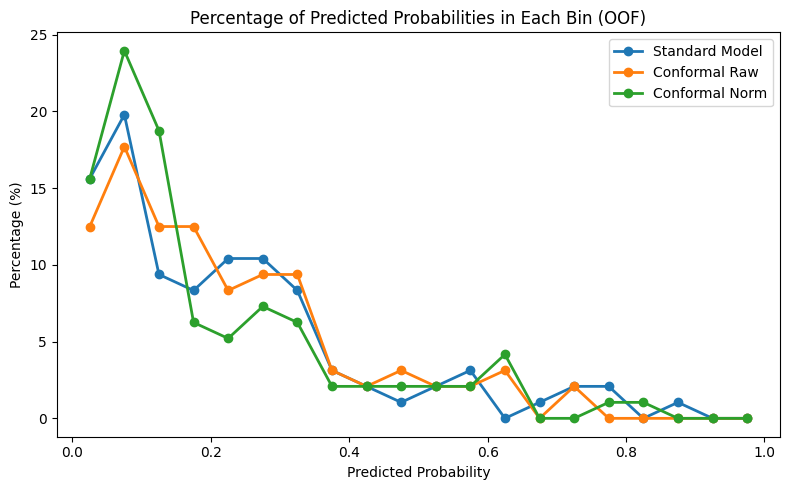

In [ ]:
import numpy as np

probs_standard = df_oof_compare["StandardModel"].to_numpy()
probs_raw = df_oof_compare["ConformalRaw"].to_numpy()
probs_norm = df_oof_compare["ConformalNorm"].to_numpy()

plt.figure(figsize=(8, 5))
bins = np.linspace(0, 1, 21)


def plot_percentage_line(probs: np.ndarray, bins: np.ndarray, label: str,
                         color: str) -> None:
    """Plot percentage of predictions in each probability bin."""
    counts, bin_edges = np.histogram(probs, bins=bins)
    percent = 100 * counts / len(probs)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(bin_centers, percent, marker="o", label=label, color=color, linewidth=2)


plot_percentage_line(probs_standard, bins, "Standard Model", "tab:blue")
plot_percentage_line(probs_raw, bins, "Conformal Raw", "tab:orange")
plot_percentage_line(probs_norm, bins, "Conformal Norm", "tab:green")

plt.xlabel("Predicted Probability")
plt.ylabel("Percentage (%)")
plt.title("Percentage of Predicted Probabilities in Each Bin (OOF)")
plt.legend()
plt.tight_layout()
plt.show()

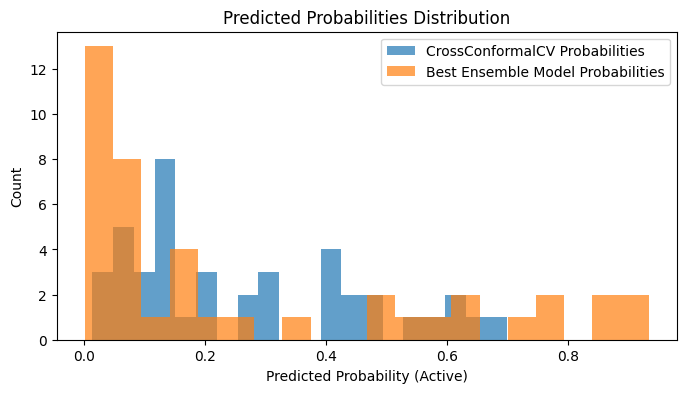

,SMILES,p0,p1,p1_norm,conformal_set,true_label
0,CC1=CC=CC=C1OC2=C(C3=C(N2C4=CC=CC=C4)N=CC=C3)C...,0.852462,0.034328,0.038711,"[0, 1]",0
1,C1CCN(CC1)C2=C(C3=CC=CC=C3N2C4=CC=CC=C4)C(=O)N...,0.632415,0.062718,0.090224,"[0, 1]",0
2,CC1=C(C=CC=C1F)CC2=C(C3=C(N2C4=CC=CC=C4)C=C(C=...,0.215403,0.307194,0.587822,[1],1
3,C1CN(CCN1)C(=O)C2=C(N(C3=C2N=CC=C3)C4=CC=CC=C4...,0.324833,0.246569,0.431516,[1],0
4,CC1=C(C=CC=C1F)CC2=C(C3=CN=C(C=C3N2C4CCCCC4)OC...,0.647592,0.059184,0.083738,"[0, 1]",0


Conformal set coverage: 0.833
Conformal set average size: 1.667
Conformal set error: 0.167
Fraction of empty sets: 0.000
NLL: 0.4559115484789948
Brier: 0.15137191487078414
AUROC: 0.7643097643097643
F1: 0.42857142857142855
MCC: 0.34555798270379956


In [ ]:
# 3.3 Visualizing Uncertainty and Prediction Sets

plt.figure(figsize=(8, 4))
plt.hist(p1, bins=20, alpha=0.7, label="Best Ensemble Model Probabilities")
plt.xlabel("Predicted Probability (Active)")
plt.ylabel("Count")
plt.legend()
plt.title("Predicted Probabilities Distribution")
plt.show()


# Get conformal prediction sets (list of sets per sample)
conf_pred_sets = cc_clf.predict_conformal_set(smiles_test, confidence=0.9)

# Get p-values for each class (p0, p1)
p_vals = cc_clf.models_[0].predict_p(smiles_test)
if hasattr(cc_clf, "models_") and len(cc_clf.models_) > 1:
    p_vals = np.mean([m.predict_p(smiles_test) for m in cc_clf.models_], axis=0)

p0 = p_vals[:, 0]
p1 = p_vals[:, 1]
p1_norm = p1 / (p0 + p1 + 1e-12)

df_cp_class = pd.DataFrame({
    "SMILES": smiles_test,
    "p0": p0,
    "p1": p1,
    "p1_norm": p1_norm,
    "conformal_set": conf_pred_sets,
    "true_label": y_test,
})
display(df_cp_class.head())


def coverage_and_set_size(y_true: np.ndarray, conf_sets: list) -> tuple[float, float]:
    """Compute coverage and average set size for conformal sets.

    Returns
    -------
    float, float
        Coverage (fraction of true labels in sets) and average set size.

    """
    covered = [y in s for y, s in zip(y_true, conf_sets, strict=True)]
    avg_size = np.mean([len(s) for s in conf_sets])
    return np.mean(covered), avg_size


coverage, avg_set_size = coverage_and_set_size(y_test, conf_pred_sets)
error = 1 - coverage
empty = np.mean([len(s) == 0 for s in conf_pred_sets])

print(f"Conformal set coverage: {coverage:.3f}")
print(f"Conformal set average size: {avg_set_size:.3f}")
print(f"Conformal set error: {error:.3f}")
print(f"Fraction of empty sets: {empty:.3f}")
print("NLL:", log_loss(y_test, p1_norm))
print("Brier:", brier_score_loss(y_test, p1_norm))
print("AUROC:", roc_auc_score(y_test, p1_norm))
print("F1:", f1_score(y_test, (p1_norm >= THRESHOLD).astype(int)))
print("MCC:", matthews_corrcoef(y_test, (p1_norm >= THRESHOLD).astype(int)))


In [ ]:
# 4. Regression: Conformal Prediction and Interval Evaluation

# --- Prepare regression data (filter NaNs as before) ---
mask_reg = ~np.isnan(X_feat).any(axis=1) & ~np.isnan(y_reg)
X_feat_reg = X_feat[mask_reg]
y_reg_clean = y_reg[mask_reg]
smiles_reg = np.array(smiles)[mask_reg]

(
    X_train_reg,
    X_test_reg,
    y_train_reg,
    y_test_reg,
    smiles_train_reg,
    smiles_test_reg,
) = train_test_split(
    X_feat_reg,
    y_reg_clean,
    smiles_reg,
    test_size=0.3,
    random_state=42,
)

# --- Wrap regressor with CrossConformalCV ---
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg_pipeline = Pipeline([
    ("rf", rf_reg),
], n_jobs=1)

cc_reg = CrossConformalCV(
    estimator=rf_reg_pipeline,
    n_folds=5,
    confidence_level=0.95,
    estimator_type="regressor",
)
cc_reg.fit(X_train_reg, y_train_reg)

# --- Predict intervals and point predictions ---
intervals = np.array([m.predict_int(X_test_reg) for m in cc_reg.models_])
intervals_mean = intervals.mean(axis=0)
lower = intervals_mean[:, 0]
upper = intervals_mean[:, 1]
point_pred = np.mean([m.predict(X_test_reg) for m in cc_reg.models_], axis=0)

df_cp_reg = pd.DataFrame({
    "pubchem_smiles": smiles_test_reg,
    "pIC50": y_test_reg,
    "pred_lower": lower,
    "pred_upper": upper,
    "point_pred": point_pred,
})
display(df_cp_reg.head())

# --- Regression: Evaluate coverage and interval width ---
coverage_reg = np.mean((y_test_reg >= lower) & (y_test_reg <= upper))
avg_width = np.mean(upper - lower)
mae = np.mean(np.abs(point_pred - y_test_reg))

print(f"Interval coverage: {coverage_reg:.3f}")
print(f"Average interval width: {avg_width:.3f}")
print(f"MAE (point prediction): {mae:.3f}")


,pubchem_smiles,pIC50,pred_lower,pred_upper,point_pred
0,CC1=C(C=C(C=C1)F)OC2=C(C3=C(N2C4=CC=CC=C4)N=CC...,6.4023,4.701805,8.831096,6.766450
1,C1CN(CCN1)C(=O)C2=C(N(C3=C2C=CN=C3)C4=CC=CC=C4...,6.1186,3.957180,8.086471,6.021825
2,CC1=C(C=CC=C1F)CC2=C(C3=C(N2C4=CC=CC=C4)N=CC(=...,8.2218,5.641988,9.771279,7.706634
3,C1CN(CCN1)C(=O)C2=C(N(C3=CC=CC=C32)C4=CC=CC=C4...,7.7447,4.515627,8.644917,6.580272
4,CC1=C(C=CC=C1F)CC2=C(C3=CNC(=O)C=C3N2C4CCCCC4)...,6.9355,4.953457,9.082748,7.018103


Interval coverage: 1.000
Average interval width: 4.129
MAE (point prediction): 0.662
